#FINRL Train Stock Trading
https://github.com/AI4Finance-LLC/FinRL/blob/master/finrl/train.py

In this work SAC used as RL agorithm rather than D Q-Network. The reason of this choice explained in "Train Model" section.

Multi-stock trading data used in train and trade data part. So this work related to multi-stock trading with RL. DOW The latest market data for all 30 stocks in the Dow Jones Industrial Average. So in this work there is "DOW_30_TICKER" relates with that.



#SETUP

In [1]:
 # Install the unstable development version in Jupyter notebook:
 !pip install git+https://github.com/AI4Finance-LLC/FinRL-Library.git

  Cloning https://github.com/AI4Finance-LLC/FinRL-Library.git to /tmp/pip-req-build-2_h1qb9c
  Running command git clone -q https://github.com/AI4Finance-LLC/FinRL-Library.git /tmp/pip-req-build-2_h1qb9c
  Cloning https://github.com/quantopian/pyfolio.git to /tmp/pip-install-fzby2pk3/pyfolio_12d906d6b4f242bca7993fdc044cea43
  Running command git clone -q https://github.com/quantopian/pyfolio.git /tmp/pip-install-fzby2pk3/pyfolio_12d906d6b4f242bca7993fdc044cea43
     |████████████████████████████████| 172 kB 13.3 MB/s 
     |████████████████████████████████| 52 kB 1.7 MB/s 
     |████████████████████████████████| 6.3 MB 62.2 MB/s 
  Created wheel for finrl: filename=finrl-0.3.0-py3-none-any.whl size=66426 sha256=f6f6328ad952d385a8431c21fe514f9bb061cec643a1adcd60cae2959b9d5a4f
  Stored in directory: /tmp/pip-ephem-wheel-cache-u1wbijh2/wheels/17/ff/bd/1bc602a0352762b0b24041b88536d803ae343ed0a711fcf55e
  Created wheel for pyfolio: filename=pyfolio-0.9.2+75.g4b901f6-py3-none-any.whl size=75

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn import preprocessing

matplotlib.use("Agg")
import datetime

from finrl.apps import config
from finrl.neo_finrl.preprocessor.yahoodownloader import YahooDownloader
from finrl.neo_finrl.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.neo_finrl.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.drl_agents.stablebaselines3.models import DRLAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

import itertools


/usr/local/lib/python3.7/dist-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


#Collect Data

In [3]:
print("==============Start Fetching Data===========")
df = YahooDownloader(
    start_date=config.START_DATE,
    end_date=config.END_DATE,
    ticker_list=config.DOW_30_TICKER,
).fetch_data()

==============Start Fetching Data===========
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1

#Feature Engineering

In [4]:
print("==============Start Feature Engineering===========")
fe = FeatureEngineer(
    use_technical_indicator=True,
    tech_indicator_list=config.TECHNICAL_INDICATORS_LIST,
    use_turbulence=True,
    user_defined_feature=False,
)

==============Start Feature Engineering===========


In [5]:
processed = fe.preprocess_data(df)


Successfully added technical indicators
Successfully added turbulence index


In [6]:
list_ticker = processed["tic"].unique().tolist()
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
combination = list(itertools.product(list_date,list_ticker))

processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date','tic'])

processed_full = processed_full.fillna(0)

# Training & Trading data split

In [7]:
train = data_split(processed_full, config.START_DATE, config.START_TRADE_DATE)
trade = data_split(processed_full, config.START_TRADE_DATE, config.END_DATE)


# Calculate state action space


In [8]:
stock_dimension = len(train.tic.unique())
state_space = (
        1
        + 2 * stock_dimension
        + len(config.TECHNICAL_INDICATORS_LIST) * stock_dimension)

# ENV CREATE

In [9]:
env_kwargs = {
        "hmax": 100, 
        "initial_amount": 100, 
        "buy_cost_pct": 0.001, 
        "sell_cost_pct": 0.001, 
        "state_space": state_space, 
        "stock_dim": stock_dimension, 
        "tech_indicator_list": config.TECHNICAL_INDICATORS_LIST, 
        "action_space": stock_dimension, 
        "reward_scaling": 1e-4
}

In [10]:
e_train_gym = StockTradingEnv(df=train, **env_kwargs)
env_train, _ = e_train_gym.get_sb_env()

#SET AGENT

In [11]:
agent = DRLAgent(env=env_train)
#DRLAGENT hazır kütüphaneden alınmakta. Kendimiz çeşitlendirebilir miyiz?

#Model Training
We use Soft Actor-Critic (SAC) for multiple stock trading, because it is one of the most recent state-of-art algorithms. SAC is featured by its stability.

For more info about SAC :https://bit.ly/3yuKz8a

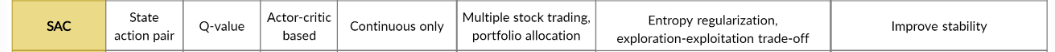

In [12]:
print("==============Model Training===========")
now = datetime.datetime.now().strftime("%Y%m%d-%Hh%M")

model_sac = agent.get_model("sac")
trained_sac = agent.train_model(model=model_sac, tb_log_name="sac", total_timesteps=80000 )

==============Model Training===========
{'batch_size': 64, 'buffer_size': 100000, 'learning_rate': 0.0001, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cuda device
Logging to tensorboard_log/sac/sac_1
---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 52       |
|    time_elapsed    | 192      |
|    total timesteps | 10064    |
| train/             |          |
|    actor_loss      | -37.7    |
|    critic_loss     | 0.0705   |
|    ent_coef        | 0.0373   |
|    ent_coef_loss   | -166     |
|    learning_rate   | 0.0001   |
|    n_updates       | 9963     |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 8        |
|    fps             | 52       |
|    time_elapsed    | 382      |
|    total timesteps | 20128    |
| train/             |          |
|    actor_loss      | -38.3    |
|    critic_loss     | 0.0715   |
|    ent

#Save Model

In [13]:
!mkdir -p saved_model
trained_sac.save('saved_model/my_model') 

In [14]:
print("==============Start Trading===========")
e_trade_gym = StockTradingEnv(df=trade, turbulence_threshold=250, **env_kwargs)

df_account_value, df_actions = DRLAgent.DRL_prediction( model=trained_sac, environment = e_trade_gym)


==============Start Trading===========
hit end!


In [15]:
df_account_value

profit_list = []
ac_val = list(df_account_value["account_value"])
print(ac_val)
turn =len(ac_val)
for i in range(turn):
  
  if i != turn-1:

    diff = ac_val[i+1]  - ac_val[i]
    profit_list.append(diff)
  else:
    profit_list.append(float(0))
    
print(profit_list)

[100.0, 98.11624255371095, 102.1722117919922, 102.39725326538087, 102.86225193023684, 102.56690280914309, 102.63358371734621, 101.73433663177494, 100.62118508148197, 102.11349465179447, 101.30191199493413, 101.55618849945074, 102.93321980667122, 100.95003750228891, 100.52762056350717, 100.4690573310853, 99.7916513557435, 99.55928181838999, 99.57807301712046, 97.57826874160777, 98.55965301895152, 96.6826693763734, 96.52401570510877, 97.77728963851942, 97.63965134048476, 98.67817215347304, 97.58247665786757, 98.6996201820375, 100.85816022110002, 101.59592907333392, 102.14854137802142, 102.65535612869282, 101.86461516189594, 102.12819548416157, 101.25936003494282, 102.05010100173969, 102.45035429763813, 103.06537504959125, 103.42658110427875, 102.99703856277485, 104.61195250320453, 104.87080967330952, 104.71458256149312, 104.22154056930562, 103.23541080856343, 103.43556034469624, 106.35977756881734, 106.07379881668112, 106.70263640213034, 106.64474148941062, 107.69645352554343, 107.430113

In [16]:
new_df = df_account_value.copy()

new_df["diff"] = np.array(profit_list)

new_df

,date,account_value,diff
0,2019-01-02,100.000000,-1.883757
1,2019-01-03,98.116243,4.055969
2,2019-01-04,102.172212,0.225041
3,2019-01-07,102.397253,0.464999
4,2019-01-08,102.862252,-0.295349
...,...,...,...
500,2020-12-24,122.372092,-0.418500
501,2020-12-28,121.953592,-0.133914
502,2020-12-29,121.819678,0.400433
503,2020-12-30,122.220111,1.885931


In [17]:
%matplotlib inline

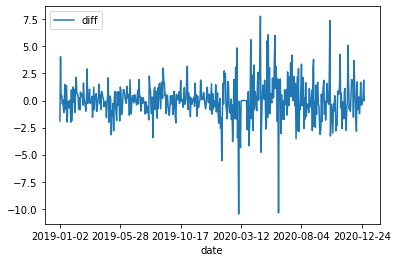

In [18]:
# hesaptaki günlük kar-zarar grafiği
new_df.plot(x='date', y='diff', kind = 'line')

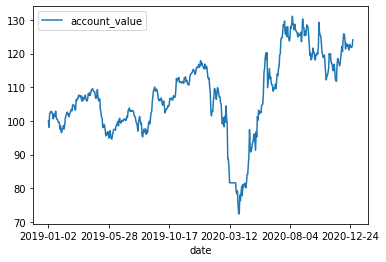

In [19]:
# total hesaptaki maliyetin değişimi
new_df.plot(x='date', y='account_value', kind = 'line')

In [20]:
trade

,date,tic,open,high,low,close,volume,day,macd,rsi_30,cci_30,dx_30,turbulence
0,2019-01-02,AAPL,38.722500,39.712502,38.557499,38.382229,148158800.0,2.0,-2.010457,37.867363,-91.579434,42.250808,51.408836
0,2019-01-02,AXP,93.910004,96.269997,93.769997,91.803406,4175400.0,2.0,-3.394947,41.204996,-97.765841,26.709417,51.408836
0,2019-01-02,BA,316.190002,323.950012,313.709991,314.645142,3292200.0,2.0,-5.550592,47.010000,-21.712382,13.611972,51.408836
0,2019-01-02,CAT,124.029999,127.879997,123.000000,117.506577,4783200.0,2.0,-0.676421,48.229088,-5.177371,0.873482,51.408836
0,2019-01-02,CSCO,42.279999,43.200001,42.209999,39.496738,23833500.0,2.0,-0.939011,44.872565,-87.556999,29.529377,51.408836
...,...,...,...,...,...,...,...,...,...,...,...,...,...
504,2020-12-31,V,218.399994,219.820007,216.199997,217.777298,5922200.0,3.0,2.239506,59.436990,232.374395,29.424279,9.382261
504,2020-12-31,VZ,58.060001,58.799999,58.020000,56.870125,12906300.0,3.0,-0.400808,46.770785,-155.773373,18.422305,9.382261
504,2020-12-31,WBA,39.330002,40.000000,39.029999,39.166107,7696000.0,3.0,0.008861,51.531879,-22.930249,0.403316,9.382261
504,2020-12-31,WMT,144.199997,144.270004,142.850006,142.464828,5938000.0,3.0,-0.847076,49.321957,-105.760414,14.356118,9.382261


In [21]:
df_actions

,AAPL,AXP,BA,CAT,CSCO,CVX,DD,DIS,GS,HD,IBM,INTC,JNJ,JPM,KO,MCD,MMM,MRK,MSFT,NKE,PFE,PG,RTX,TRV,UNH,V,VZ,WBA,WMT,XOM
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-02,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2019-01-03,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2019-01-04,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0
2019-01-07,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-2,0,0,0,0,0,0,0,1,0
2019-01-08,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0
2020-12-24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2020-12-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,-1,0,0


In [22]:
df_actions.iloc[0].sum()

1

In [23]:
df_actions.iloc[1].sum()

0

In [24]:
df_account_value

,date,account_value
0,2019-01-02,100.000000
1,2019-01-03,98.116243
2,2019-01-04,102.172212
3,2019-01-07,102.397253
4,2019-01-08,102.862252
...,...,...
500,2020-12-24,122.372092
501,2020-12-28,121.953592
502,2020-12-29,121.819678
503,2020-12-30,122.220111


In [25]:
import os
cwd = os.getcwd()
cwd

'/content'

In [26]:
import os
os.chdir('/content/saved_model')


with open("./" + "/df_account_value_" + now + ".csv", 'a') as f1:
    df_account_value.to_csv(f1, header=False)

with open("./"+ "/df_actions_" + now + ".csv", 'a') as f2:
    df_actions.to_csv(f2, header=False)




#Backtesting 

In [27]:
print("==============Get Backtest Results===========")
perf_stats_all = backtest_stats(df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./" +"/perf_stats_all_" + now + ".csv")


==============Get Backtest Results===========
Annual return          0.113791
Cumulative returns     0.241060
Annual volatility      0.269160
Sharpe ratio           0.535799
Calmar ratio           0.294671
Stability              0.196442
Max drawdown          -0.386162
Omega ratio            1.106634
Sortino ratio          0.783781
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.188557
Daily value at risk   -0.033339
dtype: float64


 #Understanding Format of Variables:

In [28]:
train

,date,tic,open,high,low,close,volume,day,macd,rsi_30,cci_30,dx_30,turbulence
0,2009-01-02,AAPL,3.067143,3.251429,3.041429,2.782837,746015200.0,4.0,0.000000,100.000000,66.666667,100.000000,0.000000
0,2009-01-02,AXP,18.570000,19.520000,18.400000,15.657365,10955700.0,4.0,0.000000,100.000000,66.666667,100.000000,0.000000
0,2009-01-02,BA,42.799999,45.560001,42.779999,33.941101,7010200.0,4.0,0.000000,100.000000,66.666667,100.000000,0.000000
0,2009-01-02,CAT,44.910000,46.980000,44.709999,32.655109,7117200.0,4.0,0.000000,100.000000,66.666667,100.000000,0.000000
0,2009-01-02,CSCO,16.410000,17.000000,16.250000,12.505757,40980600.0,4.0,0.000000,100.000000,66.666667,100.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2515,2018-12-31,V,131.679993,132.440002,130.229996,129.729263,7976000.0,0.0,-2.414906,46.509201,-59.801627,15.829088,13.602279
2515,2018-12-31,VZ,55.529999,56.230000,55.070000,50.023243,15331800.0,0.0,-0.712368,49.637841,-70.556858,14.948583,13.602279
2515,2018-12-31,WBA,68.540001,68.720001,67.739998,62.303684,4870900.0,0.0,-3.272377,38.307186,-124.296956,57.411928,13.602279
2515,2018-12-31,WMT,92.669998,93.389999,92.250000,88.752022,7005800.0,0.0,-1.466223,48.351706,-17.704925,1.938208,13.602279


In [29]:
trade

,date,tic,open,high,low,close,volume,day,macd,rsi_30,cci_30,dx_30,turbulence
0,2019-01-02,AAPL,38.722500,39.712502,38.557499,38.382229,148158800.0,2.0,-2.010457,37.867363,-91.579434,42.250808,51.408836
0,2019-01-02,AXP,93.910004,96.269997,93.769997,91.803406,4175400.0,2.0,-3.394947,41.204996,-97.765841,26.709417,51.408836
0,2019-01-02,BA,316.190002,323.950012,313.709991,314.645142,3292200.0,2.0,-5.550592,47.010000,-21.712382,13.611972,51.408836
0,2019-01-02,CAT,124.029999,127.879997,123.000000,117.506577,4783200.0,2.0,-0.676421,48.229088,-5.177371,0.873482,51.408836
0,2019-01-02,CSCO,42.279999,43.200001,42.209999,39.496738,23833500.0,2.0,-0.939011,44.872565,-87.556999,29.529377,51.408836
...,...,...,...,...,...,...,...,...,...,...,...,...,...
504,2020-12-31,V,218.399994,219.820007,216.199997,217.777298,5922200.0,3.0,2.239506,59.436990,232.374395,29.424279,9.382261
504,2020-12-31,VZ,58.060001,58.799999,58.020000,56.870125,12906300.0,3.0,-0.400808,46.770785,-155.773373,18.422305,9.382261
504,2020-12-31,WBA,39.330002,40.000000,39.029999,39.166107,7696000.0,3.0,0.008861,51.531879,-22.930249,0.403316,9.382261
504,2020-12-31,WMT,144.199997,144.270004,142.850006,142.464828,5938000.0,3.0,-0.847076,49.321957,-105.760414,14.356118,9.382261


In [30]:
e_train_gym

In [31]:
agent

In [32]:
model_sac

In [33]:
trained_sac

In [34]:
e_trade_gym

In [35]:
df_account_value

,date,account_value
0,2019-01-02,100.000000
1,2019-01-03,98.116243
2,2019-01-04,102.172212
3,2019-01-07,102.397253
4,2019-01-08,102.862252
...,...,...
500,2020-12-24,122.372092
501,2020-12-28,121.953592
502,2020-12-29,121.819678
503,2020-12-30,122.220111


In [36]:
df_actions

,AAPL,AXP,BA,CAT,CSCO,CVX,DD,DIS,GS,HD,IBM,INTC,JNJ,JPM,KO,MCD,MMM,MRK,MSFT,NKE,PFE,PG,RTX,TRV,UNH,V,VZ,WBA,WMT,XOM
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-02,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2019-01-03,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2019-01-04,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0
2019-01-07,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-2,0,0,0,0,0,0,0,1,0
2019-01-08,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0
2020-12-24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2020-12-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,-1,0,0
